In [102]:
import matplotlib.pyplot as plt
import numpy as np

from openpiv import tools, validation, filters, scaling, pyprocess
# from openpivImages import readImages, readImagesFromFolder, readImagesFromFile

import imageio
import importlib_resources
import pathlib
from PIL import Image

# Parameters
N = 4235
TOTAL_ITERATIONS = 100001
skipIterations =  220000
boxSize = 183.6
# Read images

In [103]:
dataX = []
dataV = []
dataT = []
indices = []


parentDirectory = '/home/leonardocuda/Documentos/Servicio_Social/CavityProblem/'

skipBIN = skipIterations*N*2*8

# Open the file in binary mode
with open(parentDirectory+'time_0.bin', 'rb') as f:
    # Read the data into a NumPy array
    dataT = np.fromfile(f, dtype=np.float64,offset=8*skipIterations, count=TOTAL_ITERATIONS)  # Change dtype according to your data

if(TOTAL_ITERATIONS != len(dataT)):
    print("Hubo un error, la cantidad de tiempo elapsado es: ",len(dataT))
    TOTAL_ITERATIONS = len(dataT)

with open(parentDirectory+'positions_0.bin', 'rb') as f:
    # Read the data into a NumPy array
    dataX = np.fromfile(f, dtype=np.float64, offset=skipBIN, count = 2*N*TOTAL_ITERATIONS)  # Change dtype according to your data

with open(parentDirectory+'velocities_0.bin', 'rb') as f:
    # Read the data into a NumPy array
    dataV = np.fromfile(f, dtype=np.float64, offset=skipBIN, count = 2*N*TOTAL_ITERATIONS)  # Change dtype according to your data


print(len(dataX),"   ", (TOTAL_ITERATIONS*2*N))



dataX = np.reshape(dataX, (TOTAL_ITERATIONS, N, 2))
dataV = np.reshape(dataV, (TOTAL_ITERATIONS, N, 2))
dataT = np.reshape(dataT, (TOTAL_ITERATIONS))

# dataV_magnitude = np.sqrt(dataV[:, :, 0]**2 + dataV[:, :, 1]**2)

847008470     847008470


In [ ]:
def getBitMapfromPositions(posBodies:np.ndarray, numBodies:int, x_range:tuple[float|np.float64|np.float32]\
                           ,y_range:tuple[float|np.float64|np.float32], pixelsResolution:tuple[int,int] )->np.ndarray[np.uint8]:
    assert posBodies.shape == (numBodies, 2), "Formato de posBodies incorrecto!\n"
    mod = (pixelsResolution[0]%16, pixelsResolution[1]%16)
    if mod[0] or mod[1]:
        print(f'Resolucion dada de {pixelsResolution}, pero no es divisible entre 16!\n')
        pixelsResolution = (pixelsResolution[0] - mod[0],pixelsResolution[1] - mod[1] )
        print(f'Reescalado a la siguiente resolucion: {pixelsResolution}')

    bitmap = np.zeros(pixelsResolution, dtype=np.int32)
    dx,dy = (x_range[1] - x_range[0])/pixelsResolution[0], (y_range[1] - y_range[0])/pixelsResolution[1]

    for p in range(numBodies):
        xbit = int((posBodies[p,0] - x_range[0])/dx)
        ybit = int((y_range[1] - posBodies[p,1])/dy)
        if xbit < 0 :
            xbit = 0
        if pixelsResolution[0] <= xbit:
            xbit = int(pixelsResolution[0] - 1)
        if ybit < 0:
            ybit = 0
        if pixelsResolution[1] <= ybit:
            ybit = int(pixelsResolution[1] - 1)
        bitmap[xbit, ybit] = 1

    bitmap = bitmap*255


    return bitmap
    

def preprocessBitmap(bitmap:np.ndarray[np.int32 | np.int64 | np.uint8], intensity=255)\
      -> np.ndarray[np.int32 | np.int64 | np.uint8]:
    assert bitmap.ndim == 2, "El bitmap debe ser una matriz 2D!\n"

    if bitmap.shape[0] <= 1024 and bitmap.shape[1] <= 1024:
        print("El bitmap es demasiado pequeño, no se procesara!\n")
        return bitmap
    
    levels = (bitmap.shape[0] + bitmap.shape[1]) // (2*1024)
    if levels*2*1024 < (bitmap.shape[0] + bitmap.shape[1]):
        levels += 1
    # We will assume that we would have at most 16 levels to filter
    levels = min(levels, 16)
    ### Esperamos que la resolución sea al menos unas 2 veces mayor que 1024x1024
    centers = []

    for i in range(bitmap.shape[0]):
        for j in range(bitmap.shape[1]):
            if bitmap[i,j] > 0:
                centers.append((i,j))
                bitmap[i,j] = intensity

    # Check that we have points to process
    centers = np.array(centers)
    for ij in centers:
        i, j = ij
        # No need to check for out-of-bounds since we are already iterating over the bitmap
        # The center is already at high intensity
        # Then we would like to form a tipe of circle or square around the center
        # We will use a square, in particular should be a diamond shape
        # If level is 2, H,M,L would be high, mid and low intensity

        # For level 2, we would have:
        # L M L
        # M H M 
        # L M L

        # And for level 3
        #   L N L
        # L N M N L
        # N M H M N
        # L N M N L
        #   L N L
        for k in range(1, levels + 1):
            if i - k >= 0:
                bitmap[i - k, j] = intensity
            if i + k < bitmap.shape[0]:
                bitmap[i + k, j] = intensity
            if j - k >= 0:
                bitmap[i, j - k] = intensity
            if j + k < bitmap.shape[1]:
                bitmap[i, j + k] = intensity
    

    
    return bitmap
    

In [87]:
### Arguments for the PIV part
window_size = 32
overlap = 16
timesWS = 2048//window_size # How many times the window size is multiplied to get the pixel resolution
# Resolution of the bitmap
pixelArrayResolution = (window_size*timesWS, window_size*timesWS)  # Resolution of the bitmap
skipFrame = 10  # How many frames to skip between each PIV calculation

dtElapsed = (dataT[skipFrame] - dataT[0])  # Time elapsed between frames
s2nMethod = 'peak2peak'  # Method to use for signal-to-noise ratio calculation


bitmap_a = getBitMapfromPositions(dataX[99900], N, (-boxSize*0.5, boxSize*0.5), (0, boxSize), pixelArrayResolution)
bitmap_b = getBitMapfromPositions(dataX[99900 + skipFrame], N, (-boxSize*0.5, boxSize*0.5), (0, boxSize), pixelArrayResolution)





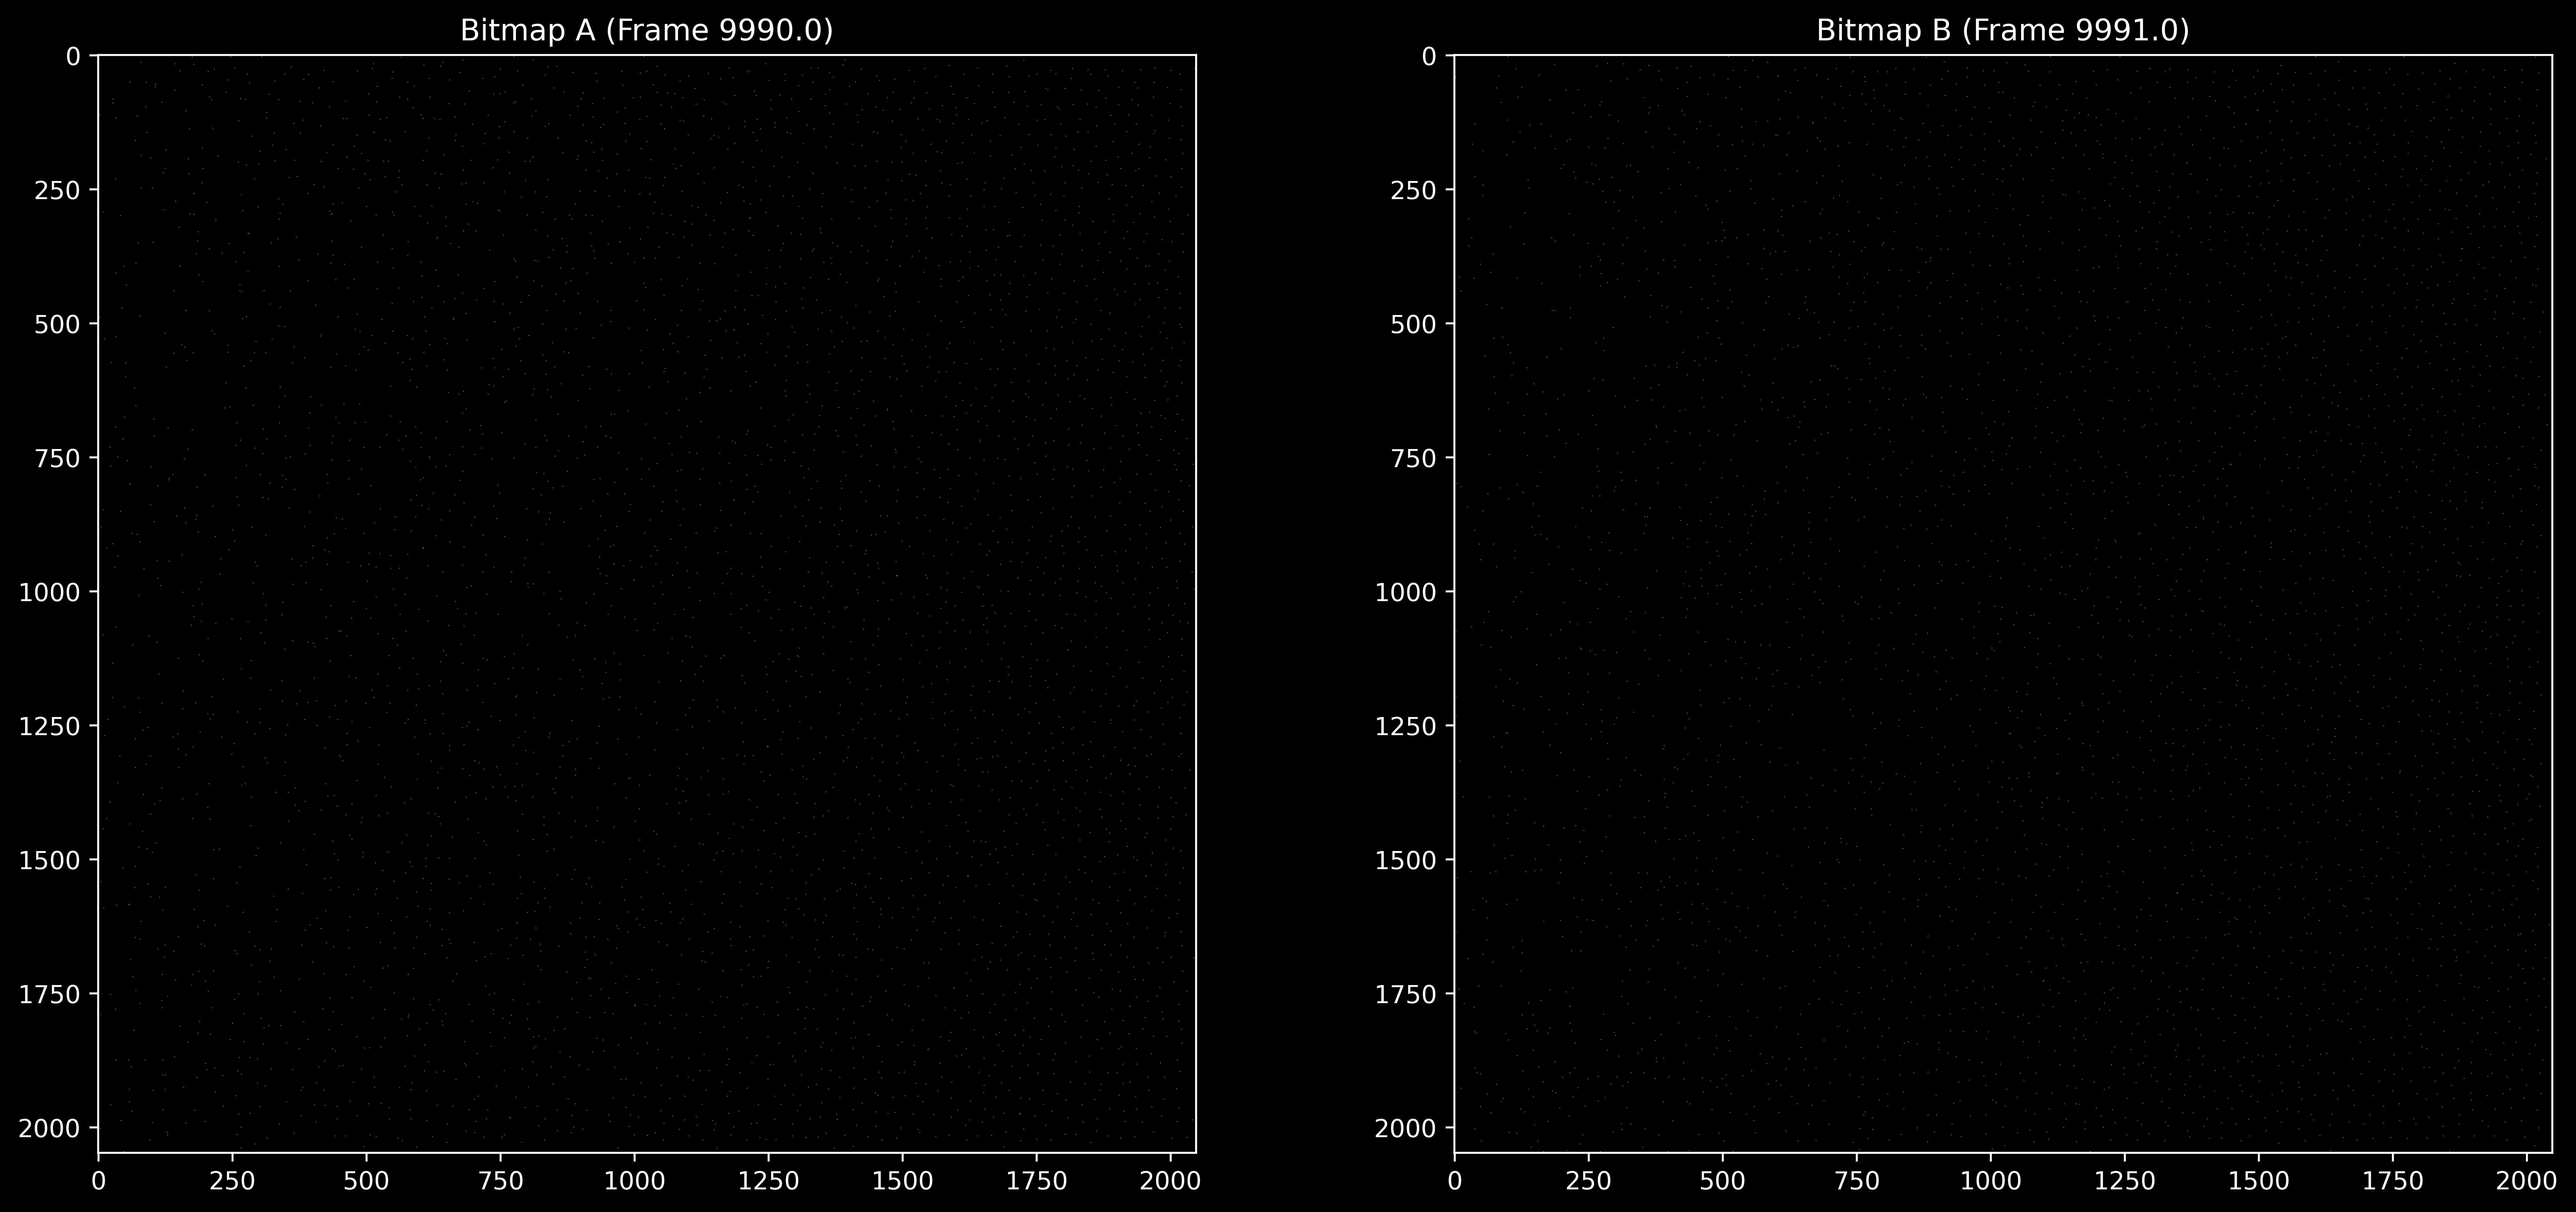

In [89]:
# plt.figure(figsize=(8, 8), dpi = 256)
plt.style.use('dark_background')
# plt.imshow(bitmap_a, cmap='gray')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), dpi=512)
ax1.imshow(bitmap_a, cmap='gray')
ax1.set_title(f'Bitmap A (Frame {dataT[99900]})')
ax2.imshow(bitmap_b, cmap='gray')
ax2.set_title(f'Bitmap B (Frame {dataT[99900 + skipFrame]})')

plt.show()
# plt.savefig('bitmap_a_b.png', dpi=256, bbox_inches='tight')
# plt.close()


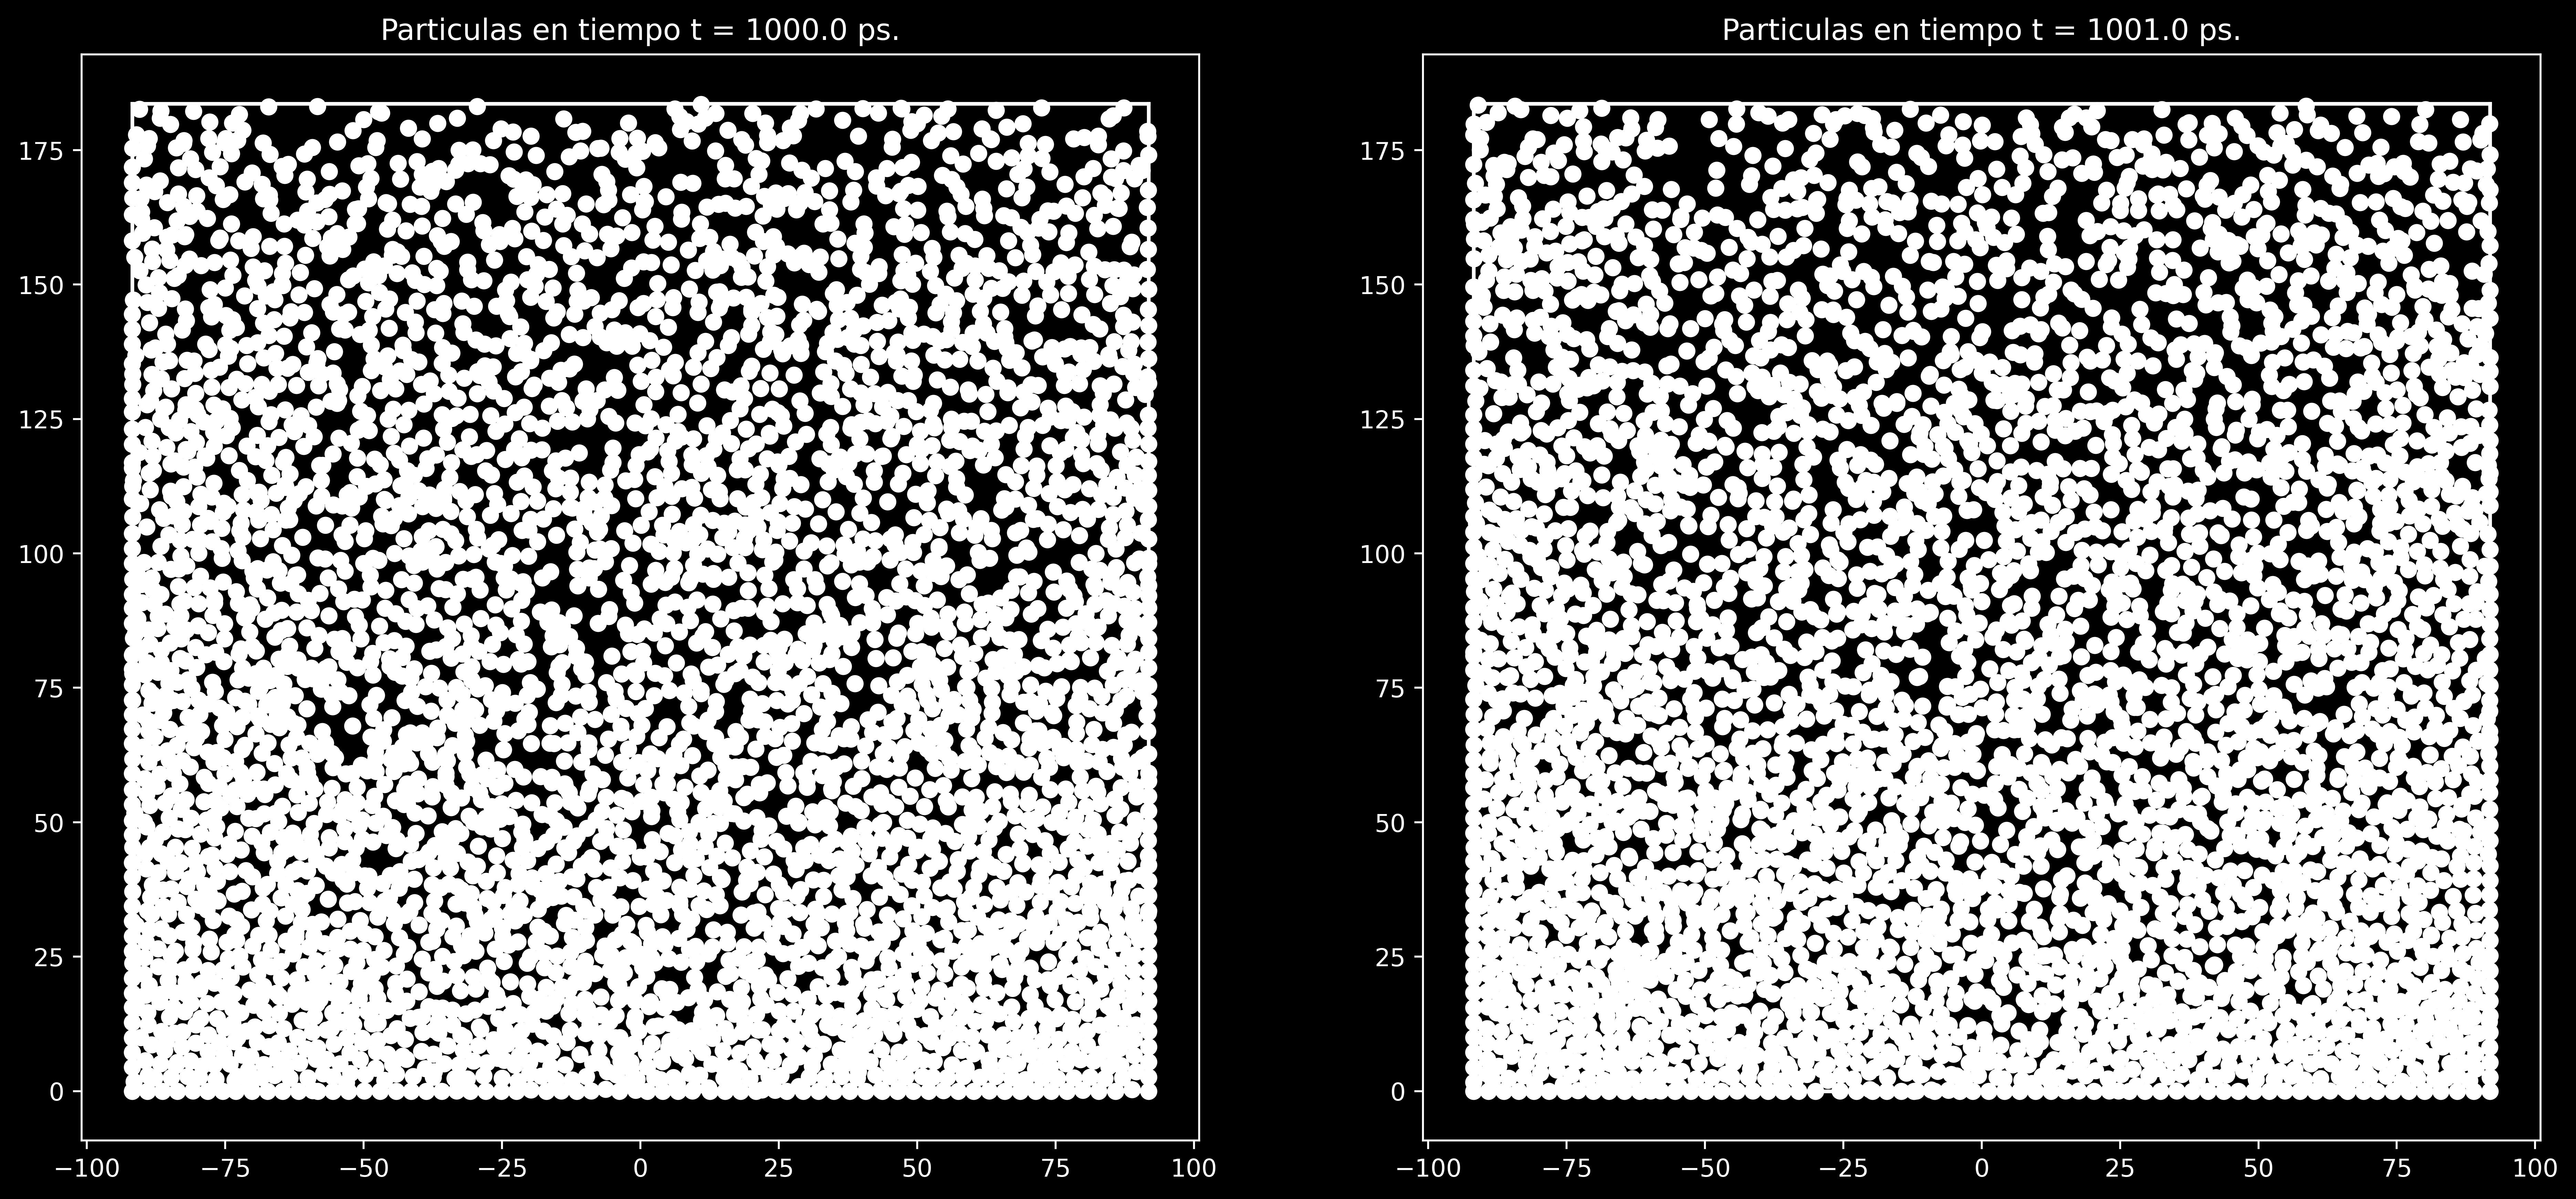

In [80]:

fig,(ax1, ax2) = plt.subplots(1,2)

fig.set_dpi(512)
fig.set_size_inches(18,8)


ax1.scatter(dataX[10000,:,0], dataX[10000,:,1], color='white')
ax1.plot([-boxSize/2.0,  boxSize/2.0],  [0.0,     0.0], color='w')
ax1.plot([ boxSize/2.0,  boxSize/2.0],  [0.0,     boxSize], color='w')
ax1.plot([ boxSize/2.0, -boxSize/2.0],  [boxSize, boxSize], color='w')
ax1.plot([-boxSize/2.0, -boxSize/2.0],  [boxSize, 0.0], color='w')
ax1.set_title(f"Particulas en tiempo t = {dataT[10000]} ps.")

ax2.scatter(dataX[10000 + skipFrame,:,0], dataX[10000 + skipFrame,:,1], color='white')
ax2.plot([-boxSize/2.0,  boxSize/2.0],  [0.0,     0.0], color='w')
ax2.plot([ boxSize/2.0,  boxSize/2.0],  [0.0,     boxSize], color='w')
ax2.plot([ boxSize/2.0, -boxSize/2.0],  [boxSize, boxSize], color='w')
ax2.plot([-boxSize/2.0, -boxSize/2.0],  [boxSize, 0.0], color='w')
ax2.set_title(f"Particulas en tiempo t = {dataT[10000 + skipFrame]} ps.")

plt.show()

u shape:  (127, 127)
v shape:  (127, 127)
sig2noise shape:  (127, 127)


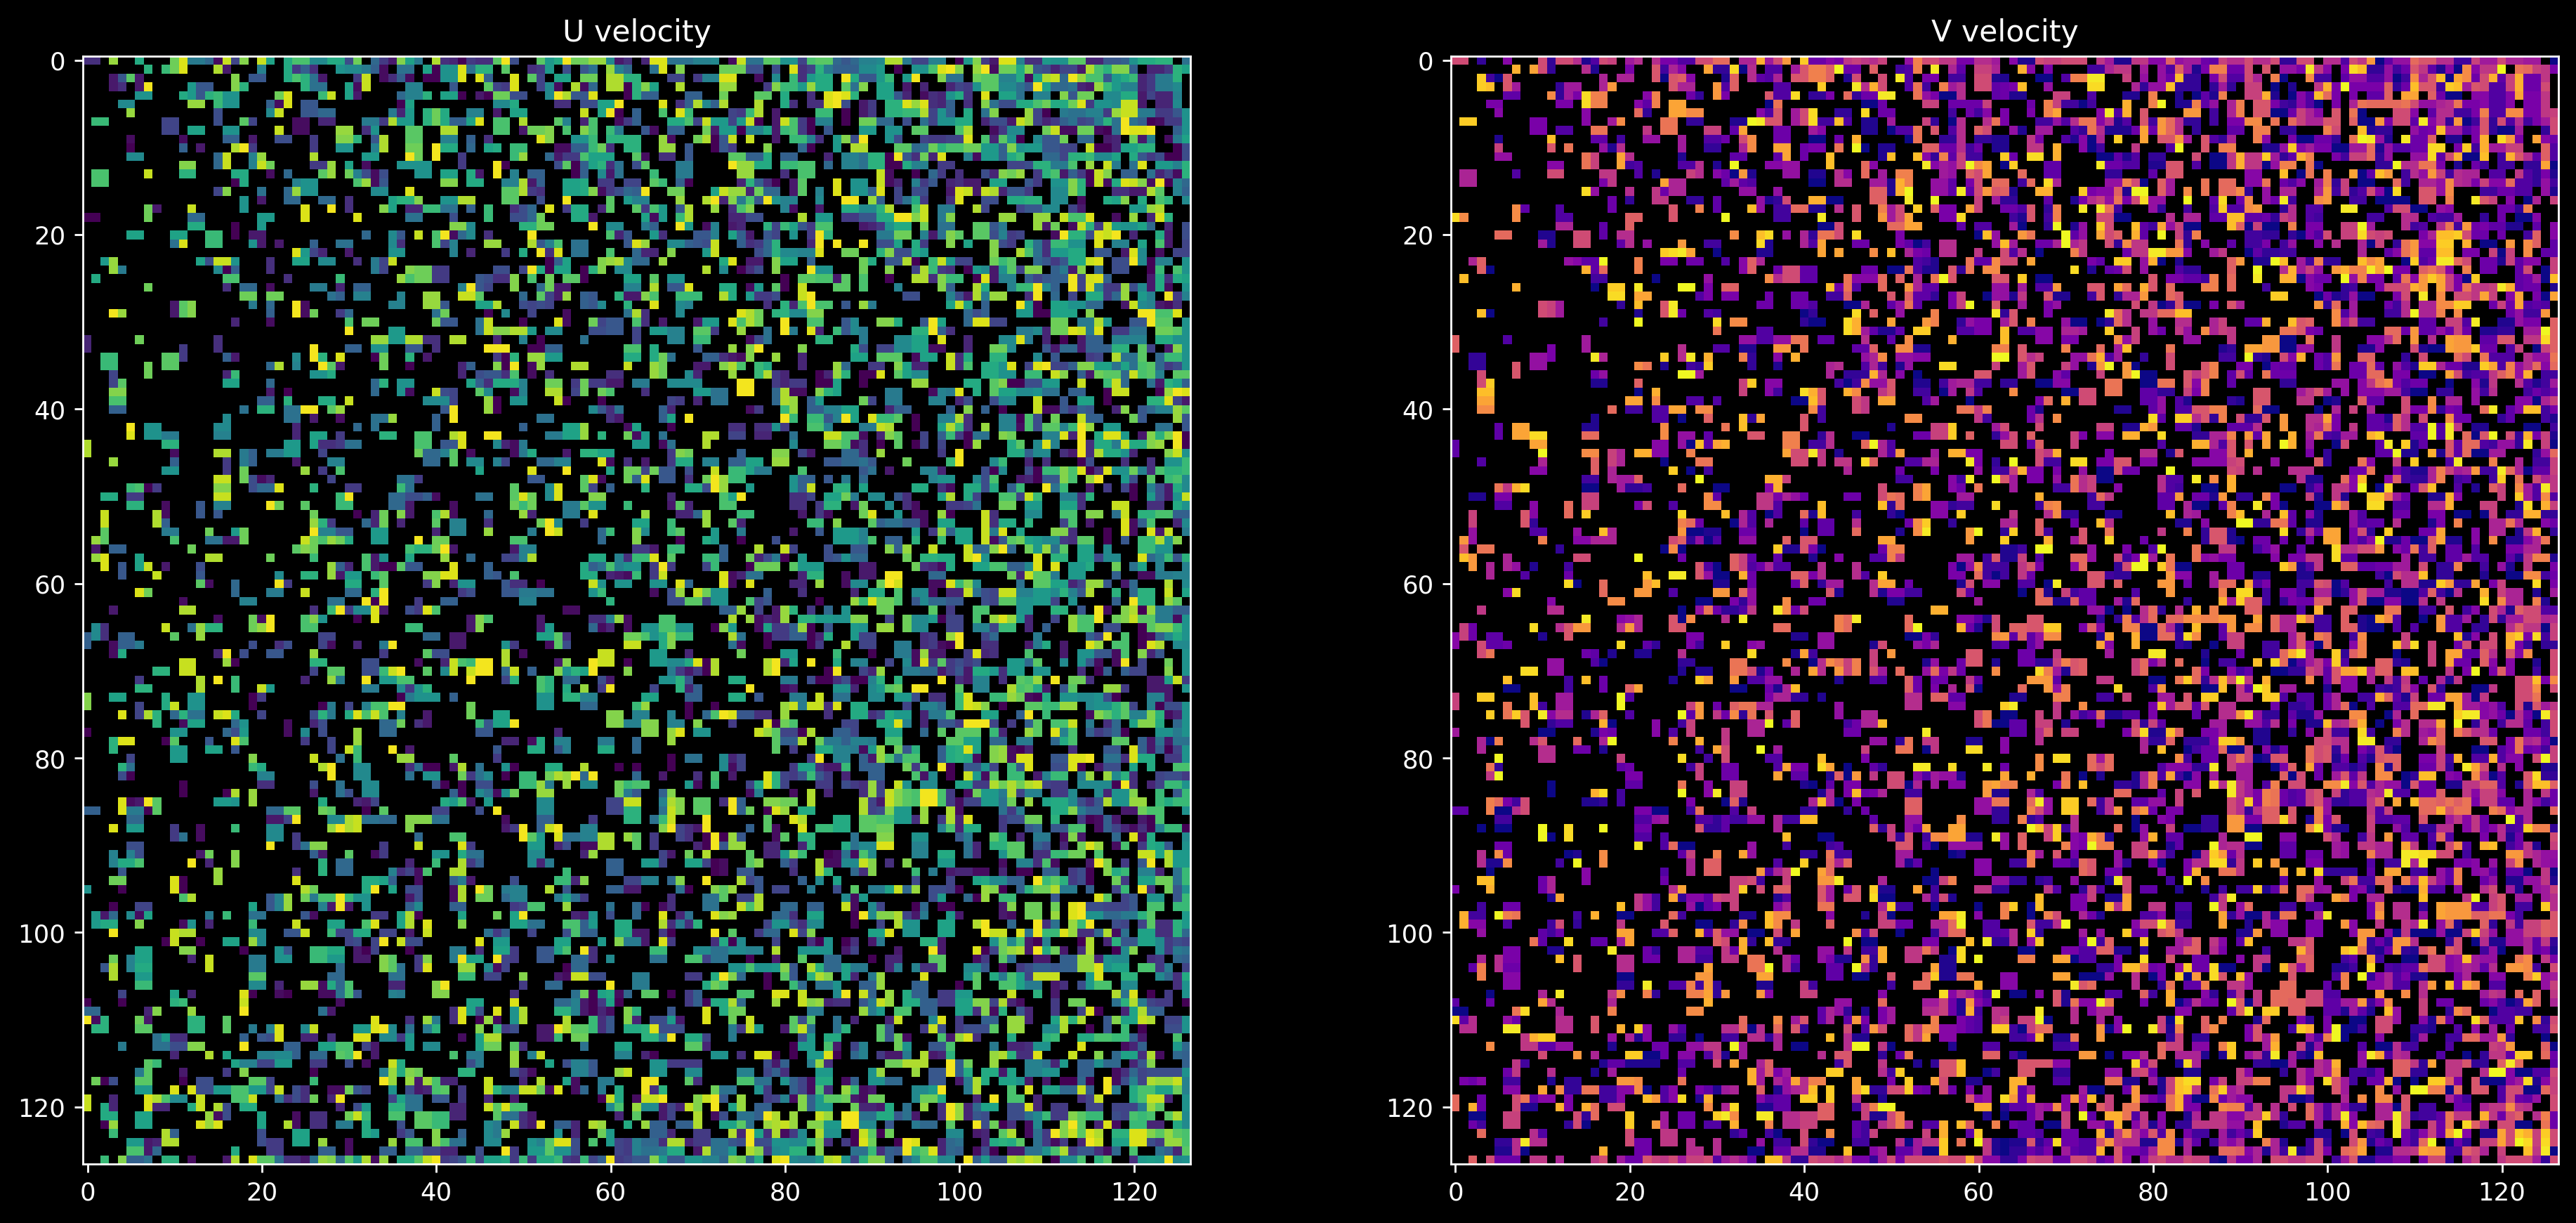

In [90]:
u,v, sig2noise = pyprocess.extended_search_area_piv(
    bitmap_a, bitmap_b, window_size=window_size, overlap=overlap,
    dt=dtElapsed, search_area_size=window_size,
    sig2noise_method=s2nMethod
)

print("u shape: ", u.shape)
print("v shape: ", v.shape)
print("sig2noise shape: ", sig2noise.shape)
# Plot the PIV results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), dpi=256)
ax1.imshow(u, cmap='viridis')
ax1.set_title('U velocity')
ax2.imshow(v, cmap='plasma')
ax2.set_title('V velocity')
plt.show()
# Save the PIV results to a file

In [91]:
x,y = pyprocess.get_coordinates(
    bitmap_a.shape, window_size, overlap,
    window_size
)

print(x, y, sep='\n\n')

[[  16.   32.   48. ... 2000. 2016. 2032.]
 [  16.   32.   48. ... 2000. 2016. 2032.]
 [  16.   32.   48. ... 2000. 2016. 2032.]
 ...
 [  16.   32.   48. ... 2000. 2016. 2032.]
 [  16.   32.   48. ... 2000. 2016. 2032.]
 [  16.   32.   48. ... 2000. 2016. 2032.]]

[[  16.   16.   16. ...   16.   16.   16.]
 [  32.   32.   32. ...   32.   32.   32.]
 [  48.   48.   48. ...   48.   48.   48.]
 ...
 [2000. 2000. 2000. ... 2000. 2000. 2000.]
 [2016. 2016. 2016. ... 2016. 2016. 2016.]
 [2032. 2032. 2032. ... 2032. 2032. 2032.]]


/home/leonardocuda/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/leonardocuda/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


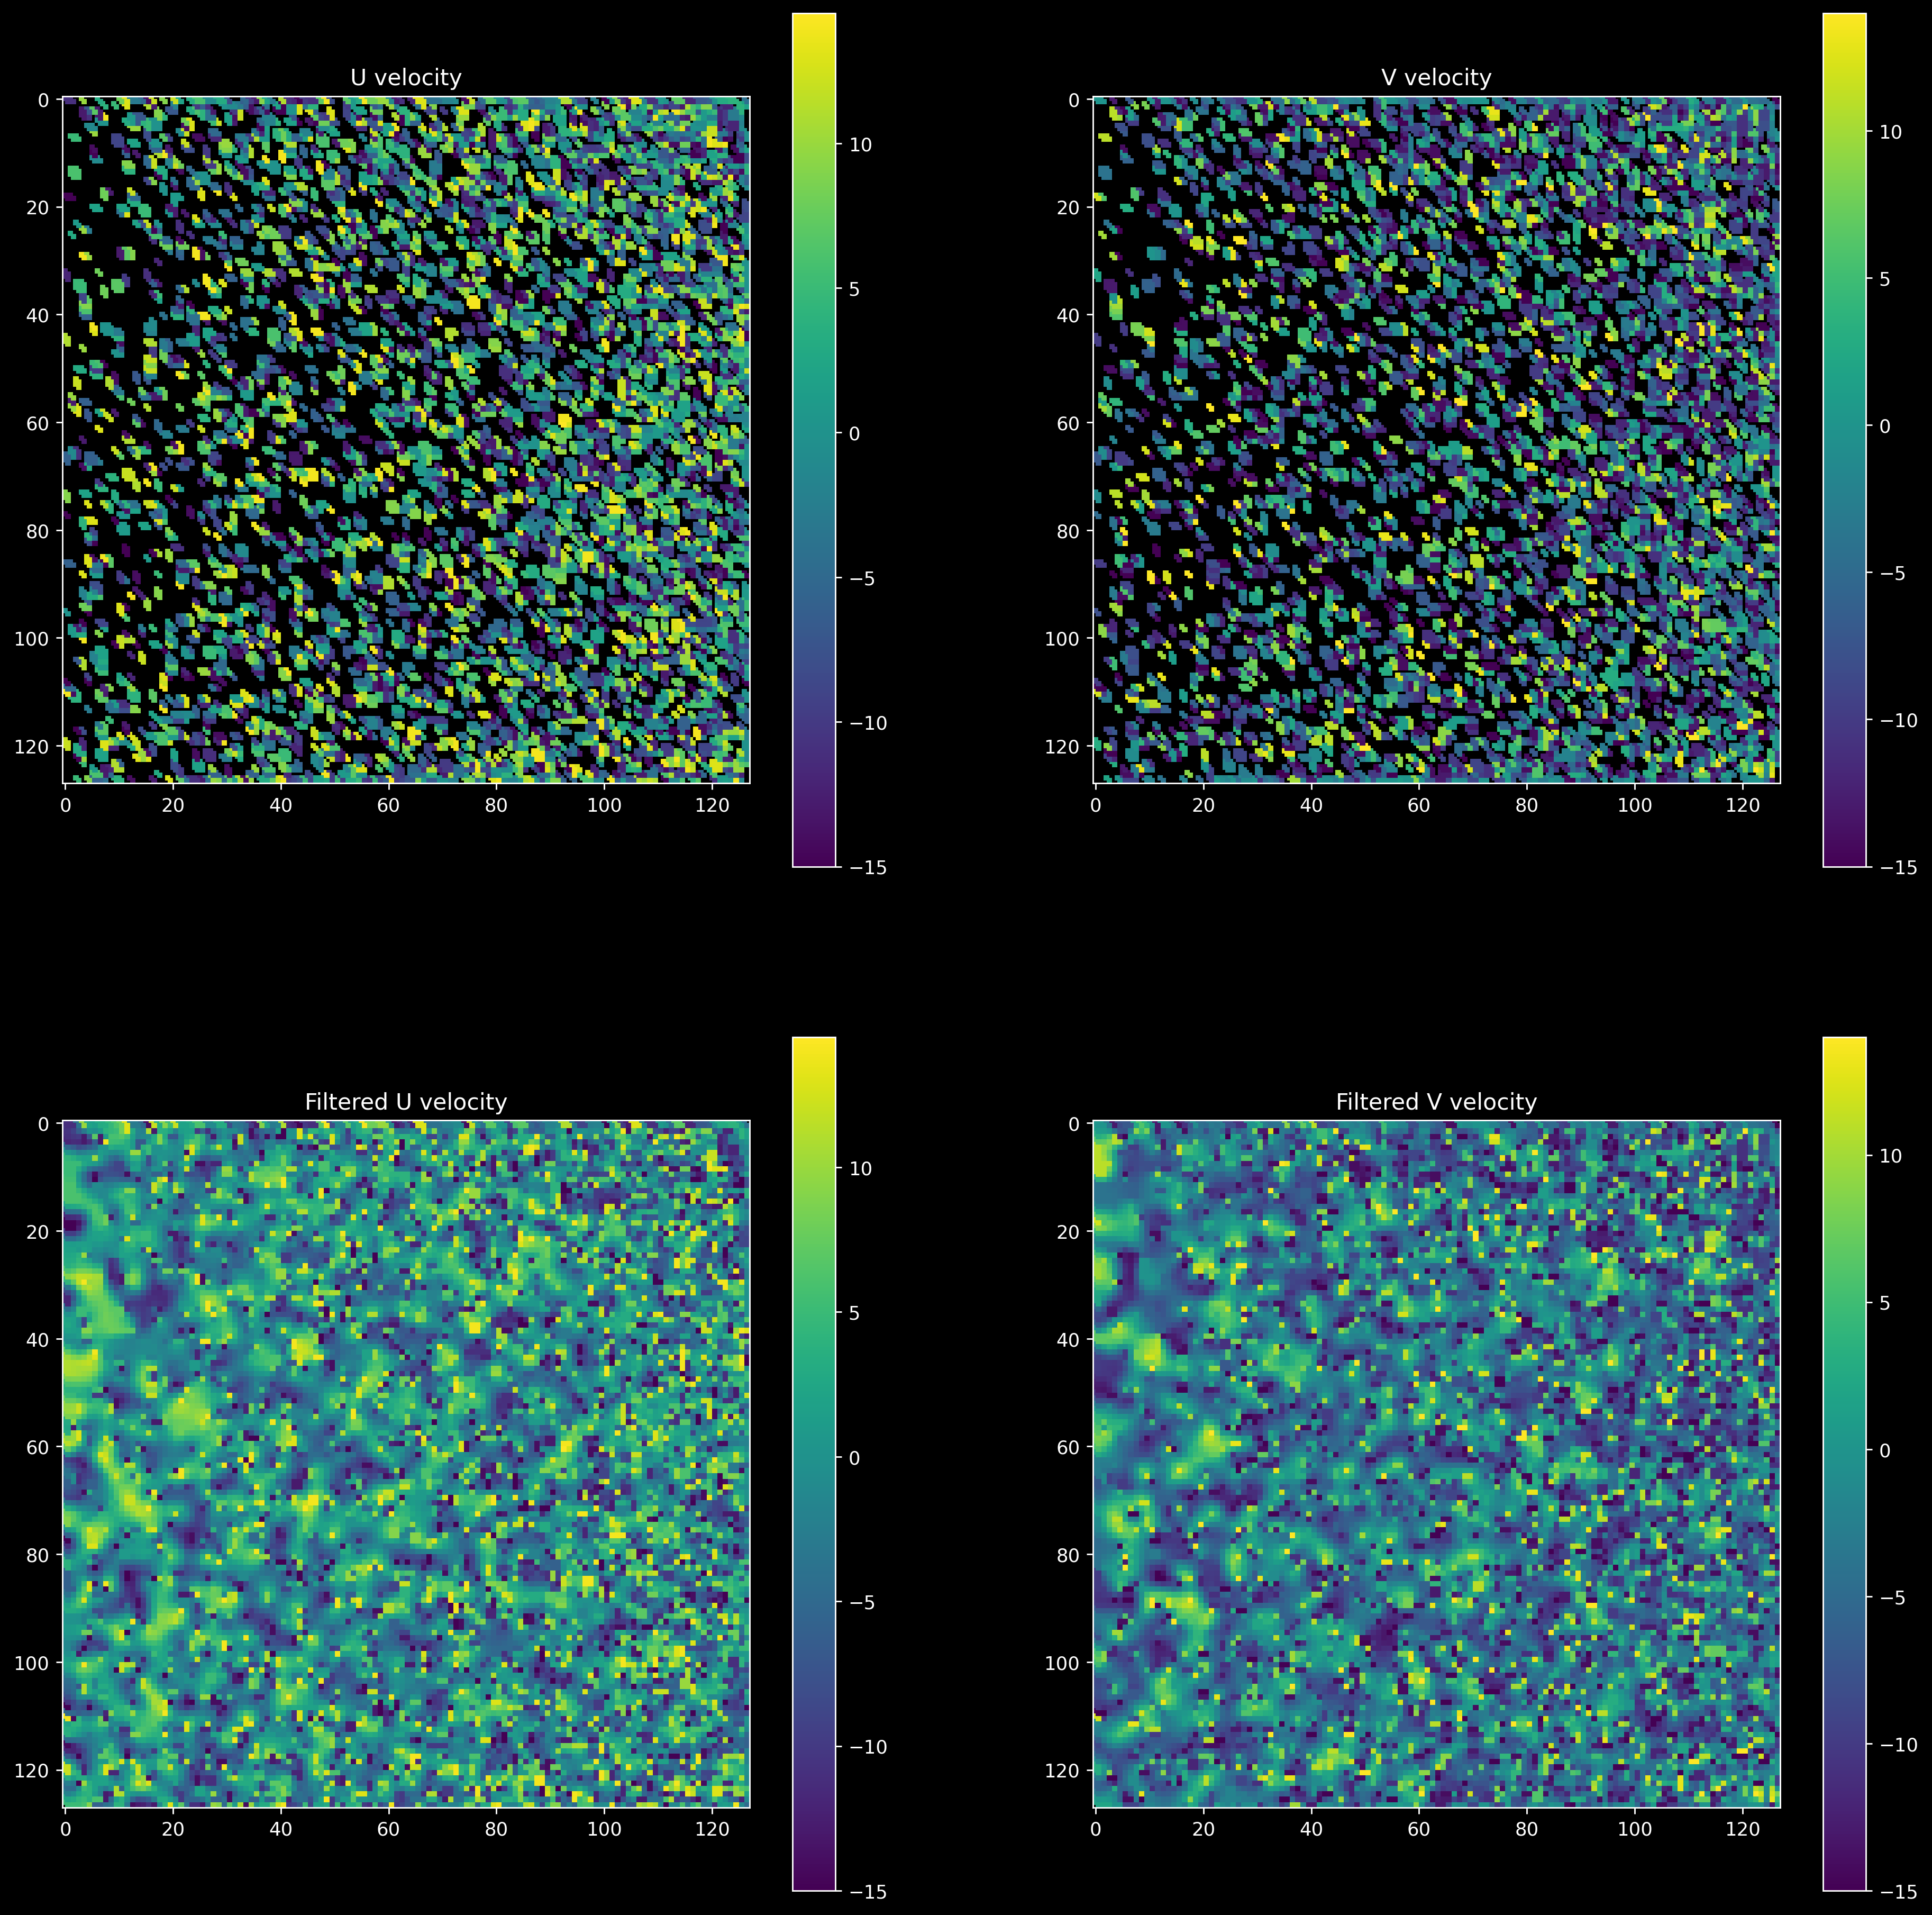

In [92]:
### Validation and filtering
valid = validation.sig2noise_val(u, v, sig2noise, threshold=0.25)
u1, v1, sig2noise = filters.replace_outliers(
    u, v, sig2noise, method='localmean', max_iter=5
)
# Plot the filtered PIV results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 18), dpi=256)

ax1.imshow(u, cmap='viridis')
ax1.set_title('U velocity')
fig.colorbar(ax1.pcolormesh(u, cmap='viridis'), ax=ax1, orientation='vertical')
ax2.imshow(v, cmap='viridis')
ax2.set_title('V velocity')
fig.colorbar(ax2.pcolormesh(v, cmap='viridis'), ax=ax2, orientation='vertical')

ax3.imshow(u1, cmap='viridis')
ax3.set_title('Filtered U velocity')
fig.colorbar(ax3.pcolormesh(u1, cmap='viridis'), ax=ax3, orientation='vertical')
ax4.imshow(v1, cmap='viridis')
ax4.set_title('Filtered V velocity')
fig.colorbar(ax4.pcolormesh(v1, cmap='viridis'), ax=ax4, orientation='vertical')
plt.show()

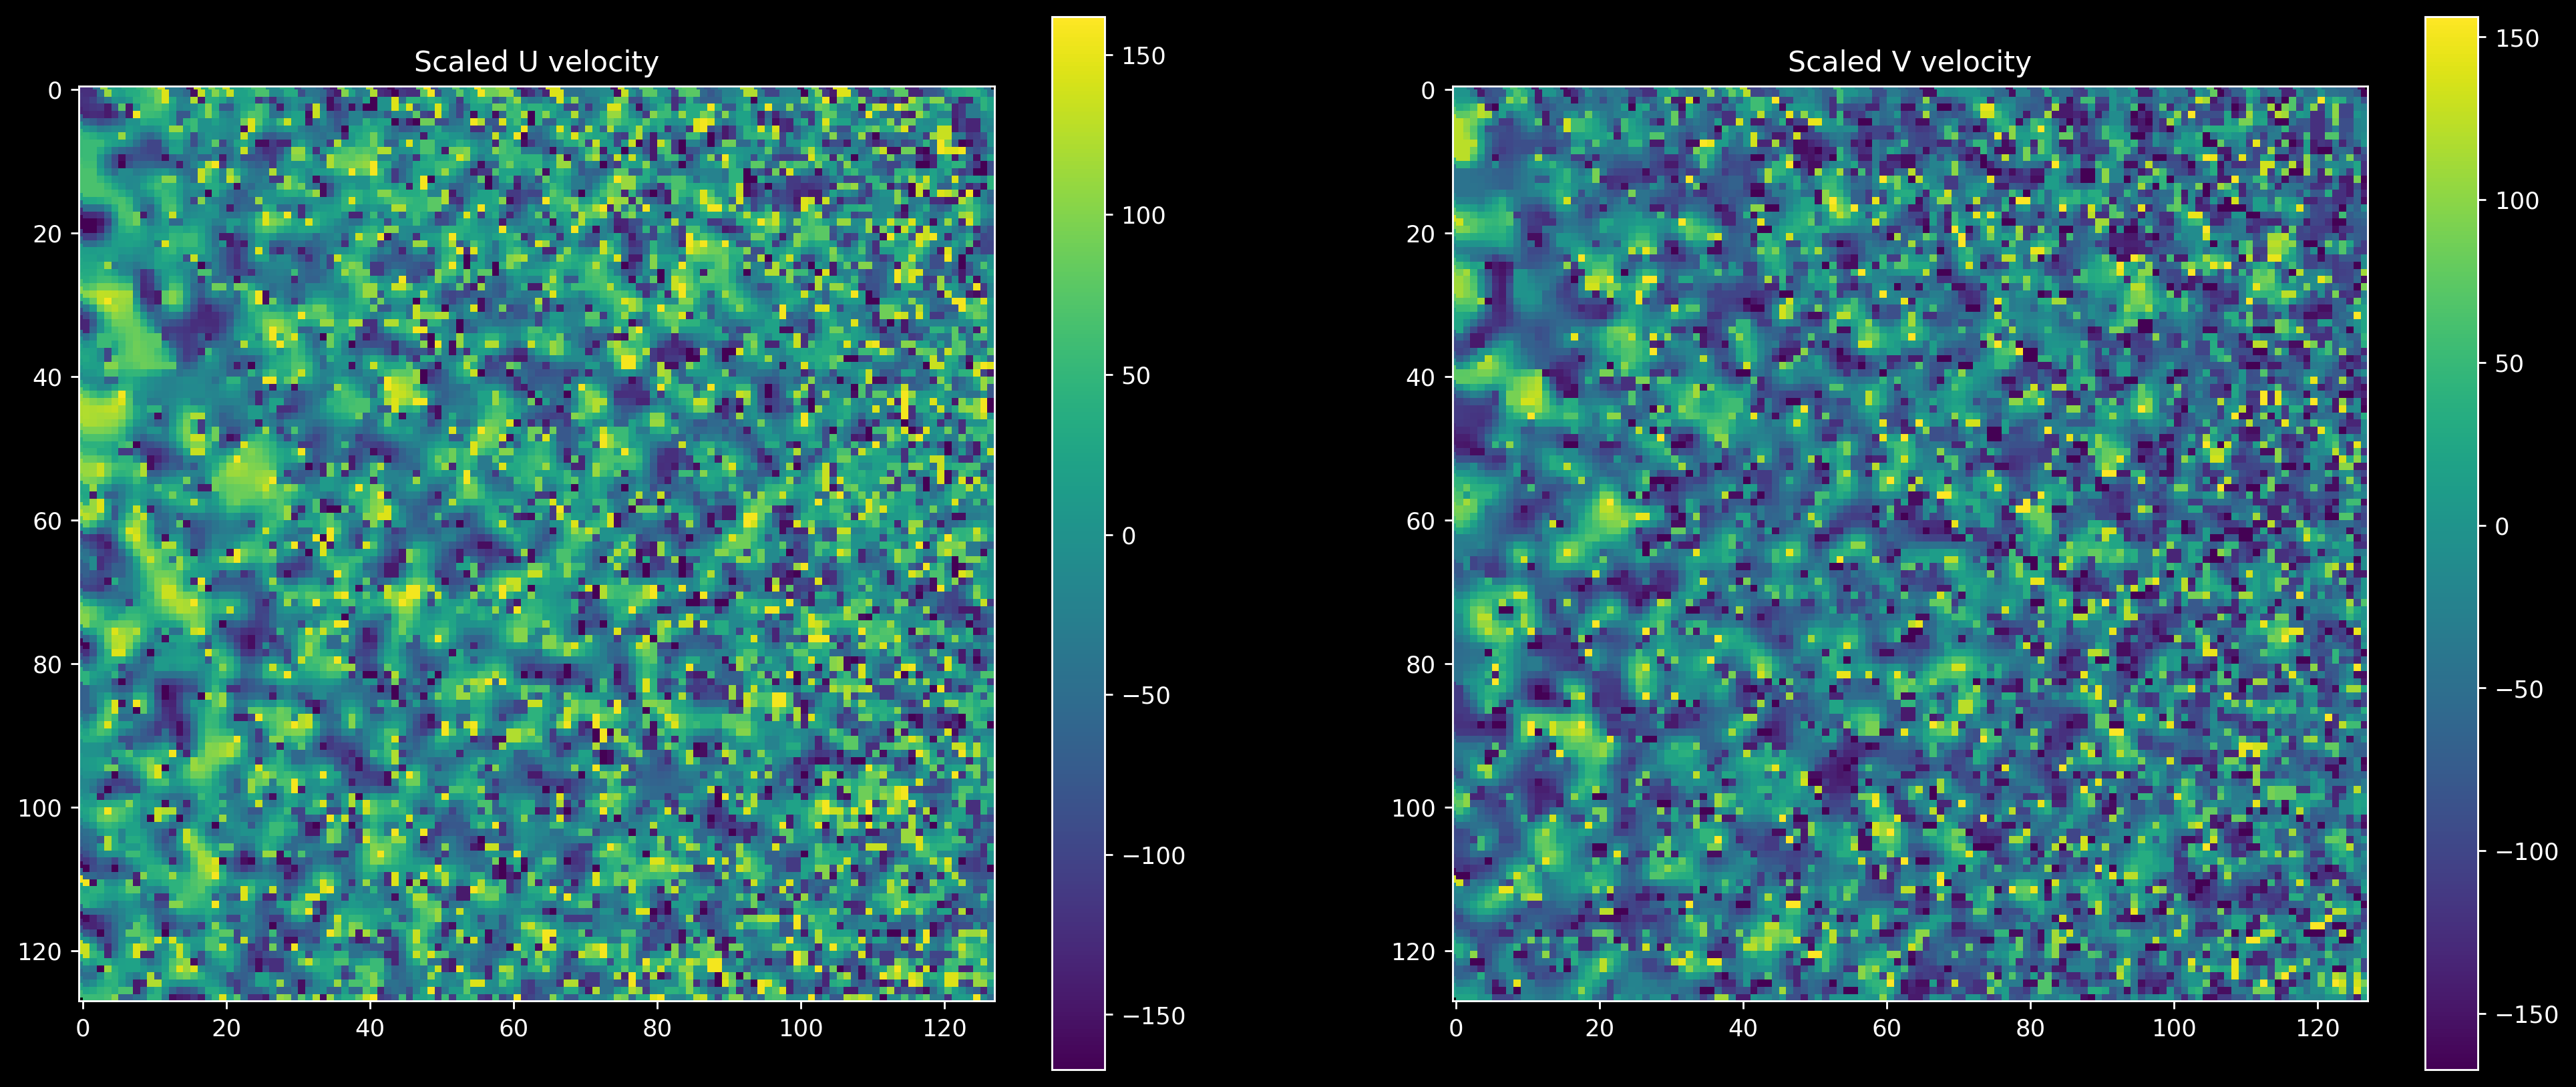

In [93]:
### Scaling the results

x1, y1, u2, v2 = scaling.uniform(
    x, y, u1, v1, scaling_factor=boxSize / pixelArrayResolution[0]
)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 8), dpi=256)
ax1.imshow(u2, cmap='viridis')
ax1.set_title('Scaled U velocity')
fig.colorbar(ax1.pcolormesh(u2, cmap='viridis'), ax=ax1, orientation='vertical')

ax2.imshow(v2, cmap='viridis')
ax2.set_title('Scaled V velocity')
fig.colorbar(ax2.pcolormesh(v2, cmap='viridis'), ax=ax2, orientation='vertical')
plt.show()

x1 shape:  (127, 127)
y1 shape:  (127, 127)
u2 shape:  (127, 127)
v2 shape:  (127, 127)


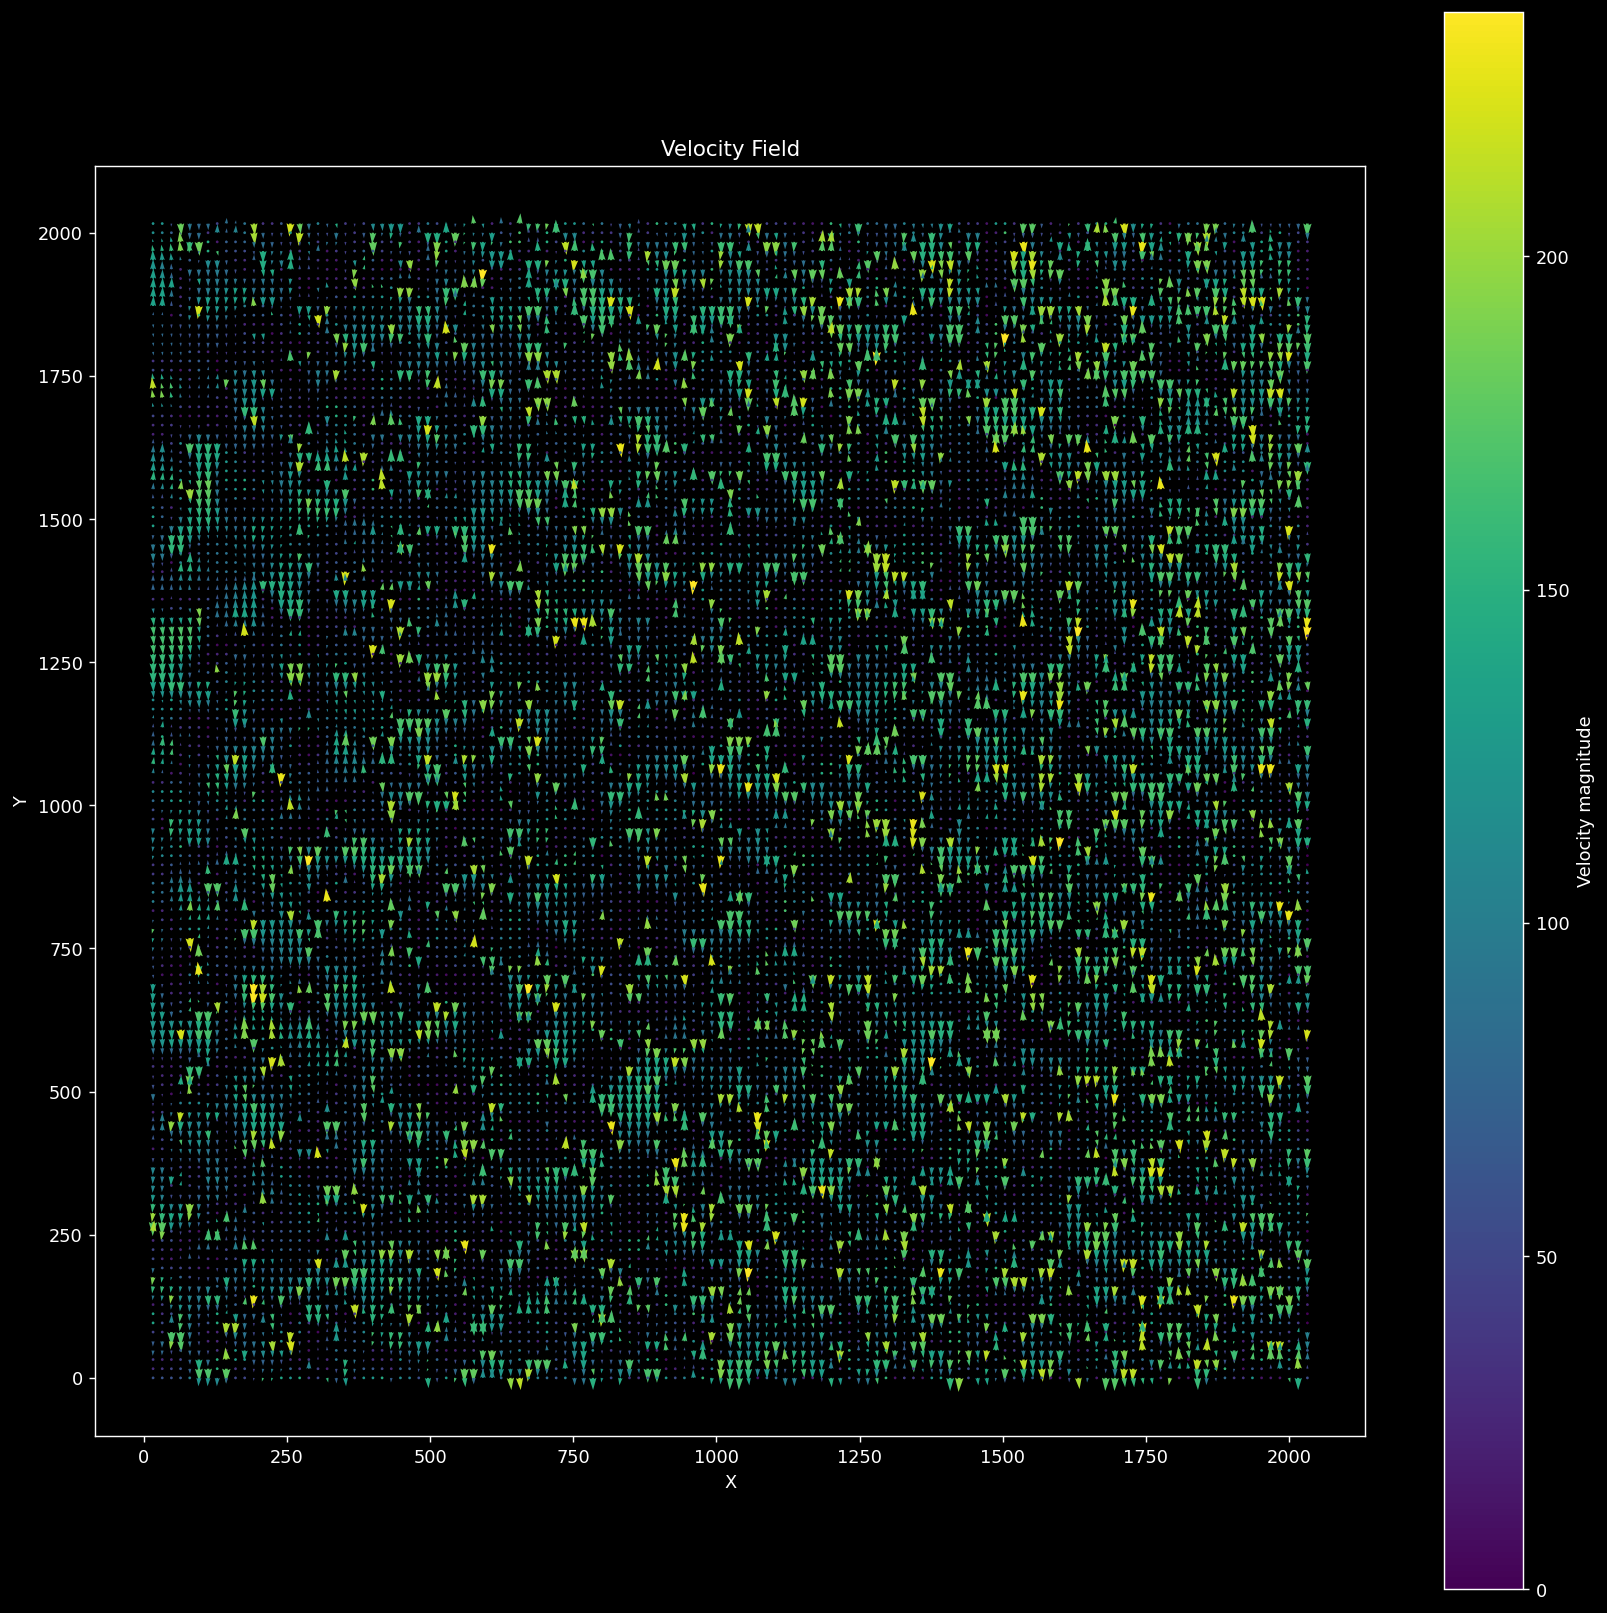

In [94]:
# ...existing code...

print("x1 shape: ", x1.shape)
print("y1 shape: ", y1.shape)
print("u2 shape: ", u2.shape)
print("v2 shape: ", v2.shape)

plt.figure(figsize=(16, 16), dpi=128)
plt.quiver(x, y.max() - y, u1, v2, np.sqrt(u2**2 + v2**2), cmap='viridis')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Velocity Field')
plt.colorbar(label='Velocity magnitude')
plt.gca().set_aspect('equal')
plt.show()
# ...existing code...

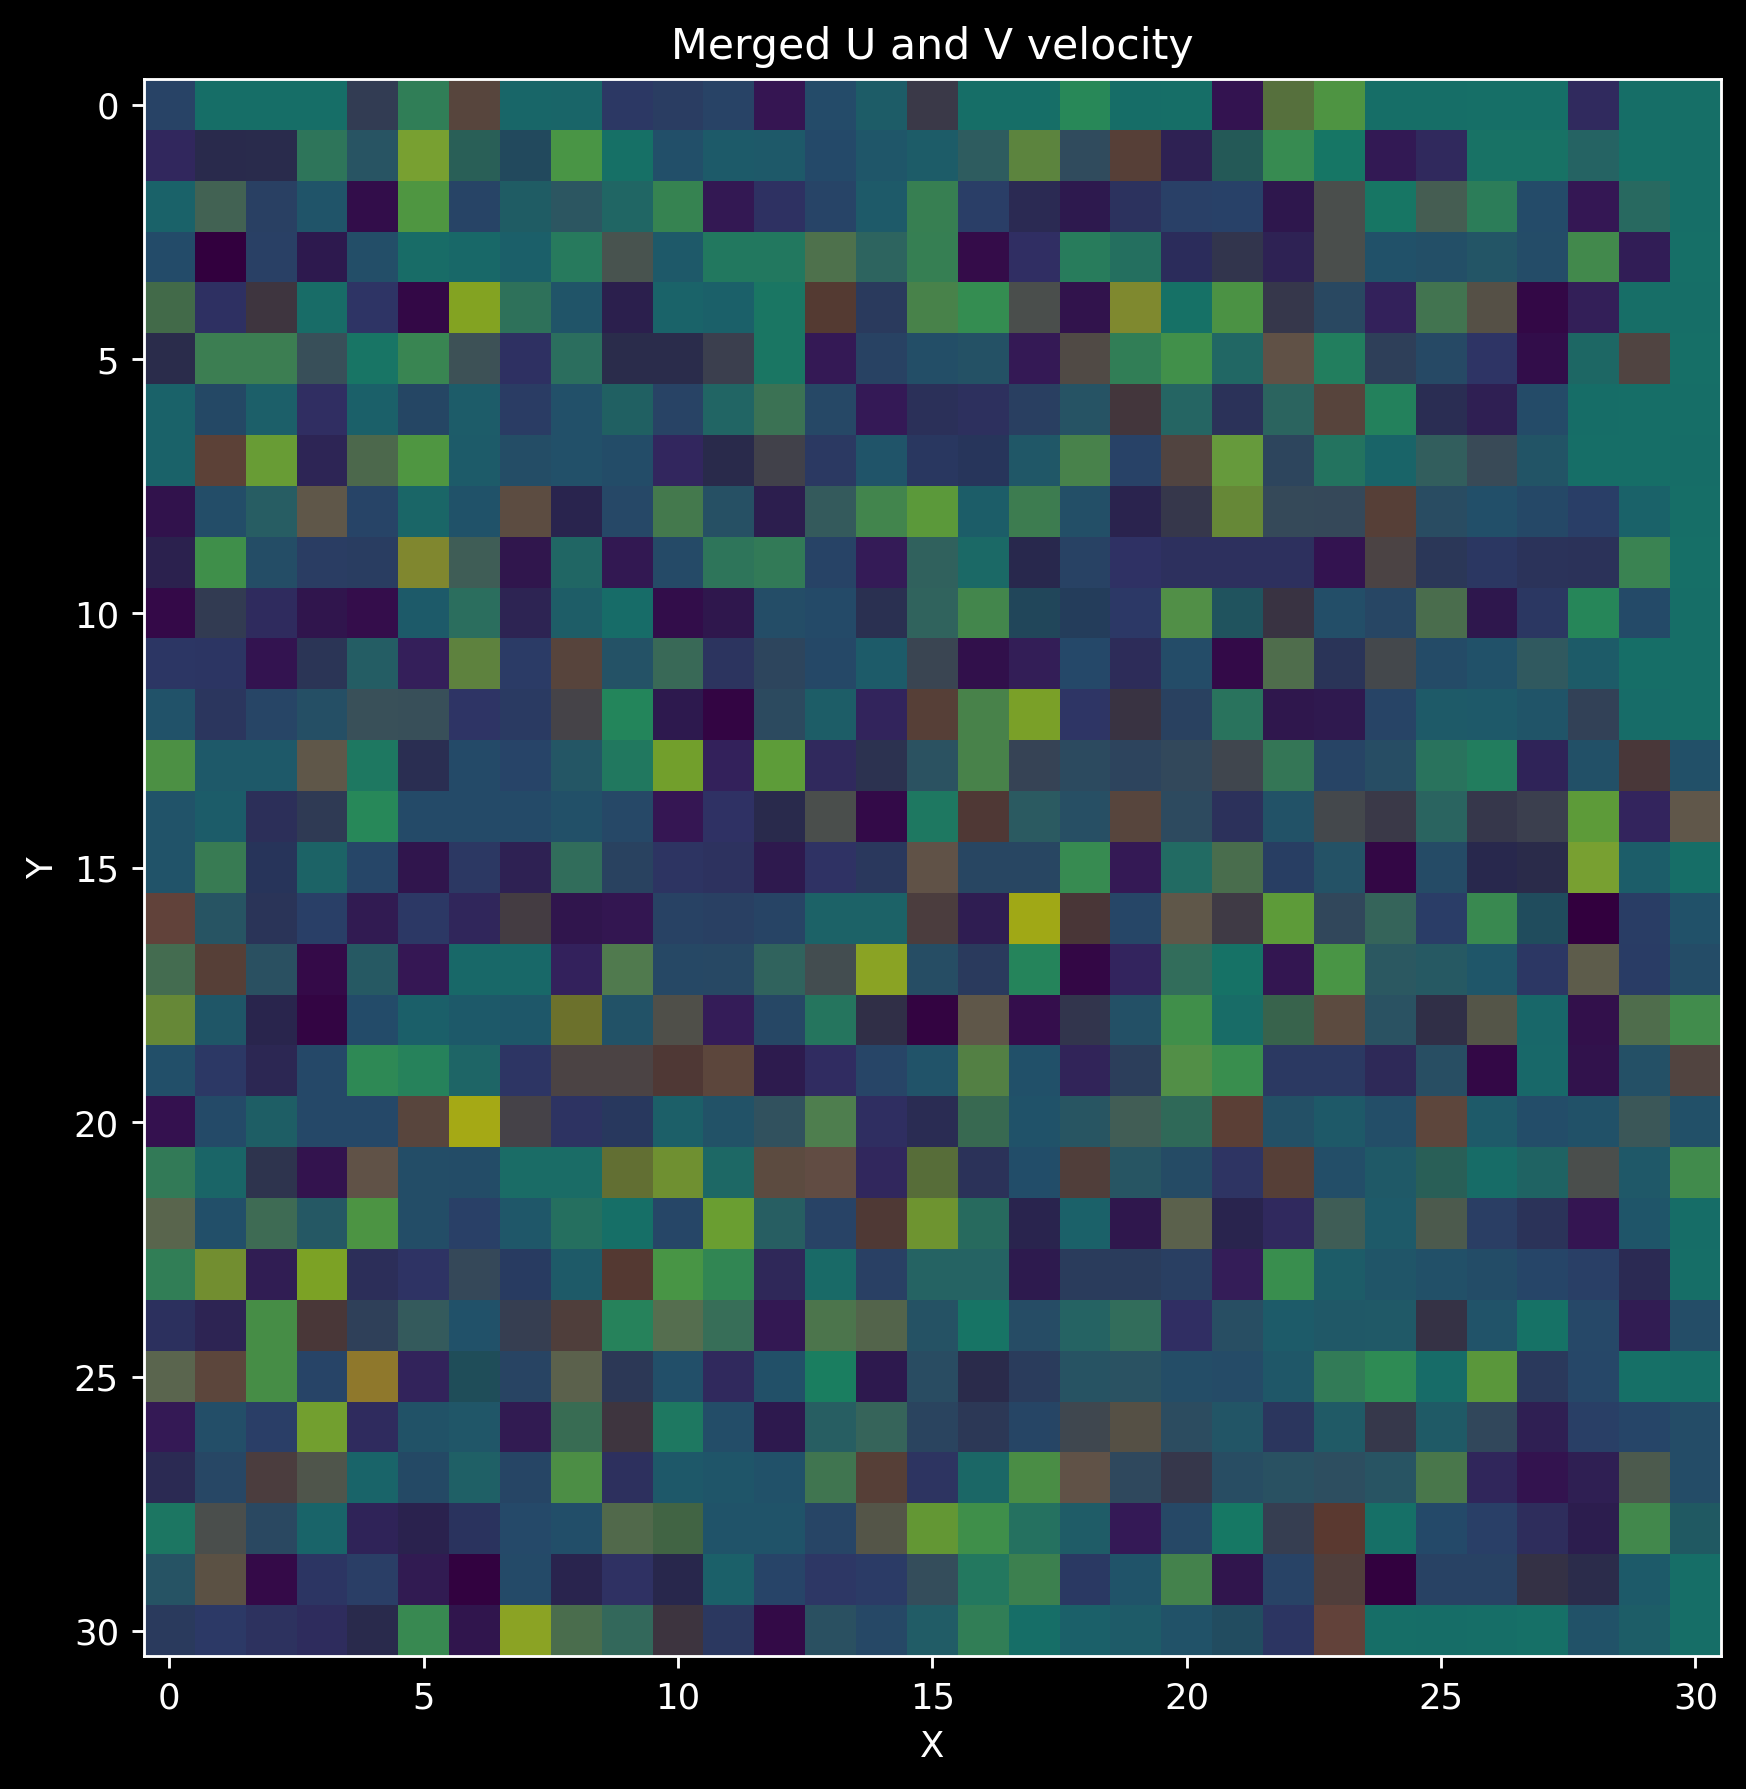

In [13]:
### Merging U and V into a single array

fig, ax = plt.subplots(1, figsize=(9, 8), dpi=256)

ax.imshow(u1, cmap='viridis', alpha=0.5)  # Overlay U on V with some transparency
ax.imshow(v1, cmap='viridis', alpha=0.5)  # Overlay V on U with some transparency
ax.set_title('Merged U and V velocity')
ax.set_xlabel('X')
ax.set_ylabel('Y')
# plt.colorbar(label='Velocity magnitude')
plt.show()

In [95]:
def getPositionsFromPixelArray(pixPosX:np.ndarray, pixPosY:np.ndarray, xlims:tuple[float|np.float64|np.float32], ylims:tuple[float|np.float64|np.float32], \
                               pixelArrayResolution:tuple[int,int])->np.ndarray[np.float64|np.float32]:
    """
    Get the positions of the particles from the pixel array. 

    """
    assert pixPosX.ndim == 2 and pixPosY.ndim == 2, "Pixel postions must be a 2D array!"
    assert pixPosX.shape == pixPosY.shape, "pixPosX and pixPosY must have the same shape!"

    
    dx = (xlims[1] - xlims[0]) / pixelArrayResolution[0]
    dy = (ylims[1] - ylims[0]) / pixelArrayResolution[1]
    positionsX = np.zeros(pixPosX.shape, dtype=np.float64)
    positionsY = np.zeros(pixPosY.shape, dtype=np.float64)

    for i in range(pixPosX.shape[0]):
        for j in range(pixPosY.shape[1]):
            positionsX[i, j] = xlims[0] + (pixPosX[i,j] + 0.5) * dx 
            positionsY[i, j] = ylims[1] - (pixPosY[i,j] + 0.5) * dy

    return positionsX, positionsY


def getVelocityFieldFromPIV(X0:np.ndarray[np.float64|np.float32], X1:np.ndarray[np.float64|np.float32],\
            xlims:tuple[float|np.float64|np.float32], ylims:tuple[float|np.float64|np.float32], \
             genImage=False, numParticles=4235  )->\
    tuple[np.ndarray[np.float32|np.float64],np.ndarray[np.float32|np.float64], np.ndarray[np.float32|np.float64], np.ndarray[np.float32|np.float64]]:
    """
    Get the velocity field from the PIV results.
    """
    assert X0.shape == X1.shape, "U and V must have the same shape!"

    # Now lets generate the framesA,B from X0 and X1

    frameA = getBitMapfromPositions(X0, numParticles, xlims, ylims, pixelArrayResolution)
    frameB = getBitMapfromPositions(X1, numParticles, xlims, ylims, pixelArrayResolution)

    u, v, sig2noise = pyprocess.extended_search_area_piv(
        frameA, frameB, window_size=window_size, overlap=overlap,
        dt=dtElapsed, search_area_size=window_size,
        sig2noise_method=s2nMethod, subpixel_method='gaussian'
    )

    # Validate and filter the results
    valid = validation.sig2noise_val(u, v, sig2noise, threshold=1.05)
    u1, v1, sig2noise = filters.replace_outliers(
        u, v, sig2noise, method='localmean', max_iter=3
    )

    # Scale the results
    x, y = pyprocess.get_coordinates(
        frameA.shape, window_size, overlap,
        window_size
    )
    x1, y1, u2, v2 = scaling.uniform(
        x, y, u1, v1, scaling_factor=boxSize / pixelArrayResolution[0]
    )

    ### Now we need to shift pass the coordinates of (x1, y1) to the real coordinates of the simulation
    x2, y2 = getPositionsFromPixelArray(
        x, y, xlims, ylims, pixelArrayResolution
    )

    if genImage:
        fig, ax = plt.subplots(1, figsize=(9, 9), dpi=256)
        ax.quiver(x2, y2, u2, v2, np.sqrt(u2**2 + v2**2), cmap='viridis')
        ax.set_xlabel('X (Amgstrom)')
        ax.set_ylabel('Y (Amgstrom)')
        ax.set_title('Velocity Field from Particles')

        return x2, y2, u2, v2, fig, ax
    
    return x2, y2, u2, v2


In [104]:
### Supongamos que tendremos mas frames de separacion, luego

skipFrame = 2000  # How many frames to skip between each PIV calculation
dtElapsed = (dataT[skipFrame] - dataT[0])  # Time elapsed between frames

parentDirectoryPIV = '/home/leonardocuda/Documentos/Servicio_Social/CavityProblem/dataManipulationPrograms/openpivImages/'

# frameA = getBitMapfromPositions(dataX[0], N, (-boxSize*0.5, boxSize*0.5), (0, boxSize), pixelArrayResolution)
currFrame = 80000 + skipFrame  # Start from the first frame after the initial one

while currFrame < TOTAL_ITERATIONS:
    # frameB = getBitMapfromPositions(dataX[currFrame], N, (-boxSize*0.5, boxSize*0.5), (0, boxSize), pixelArrayResolution)
    
    x2, y2, u2, v2, fig, ax = getVelocityFieldFromPIV(
        dataX[currFrame], dataX[currFrame - skipFrame],
        xlims=(-boxSize*0.5, boxSize*0.5), ylims=(0, boxSize),
        genImage=True
    )
    
    ax.set_title(f'Velocity Field from Particles time t = {dataT[currFrame]} ps')

    fig.savefig(parentDirectoryPIV + f'frame_VF_from_PIV{currFrame}.png', dpi=256, bbox_inches='tight', )
    plt.close(fig)  # Close the figure to free memory

    del fig, ax  # Clear the figure to free memory
    
    # Update frameA for the next iteration
    currFrame += 1

KeyboardInterrupt: 